In [ ]:
import numpy as np 
import pandas as pd 
import os
import json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, Dropout, Flatten
from keras.models import Model, Sequential
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
from sklearn.svm import SVC
!pip install transformers
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
!pip install lime
import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
import nltk 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path1 = '/content/drive/MyDrive/data/Sarcasm_Headlines_Dataset.json'
path2 = '/content/drive/MyDrive/data/Sarcasm_Headlines_Dataset_v2.json'
def read_json_file(filepath):
    return pd.DataFrame.from_dict([json.loads(line) for line in open(filepath, 'r')])

df = pd.concat([read_json_file(path1), read_json_file(path2)])


In [ ]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df2= pd.read_csv('/content/drive/MyDrive/data/train-balanced-sarcasm.csv')
df2.drop(['author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'], axis=1, inplace=True)
df2.dropna(inplace=True)

In [ ]:
df2.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


Data Processor of Deep Learning models for News Headline Dataset

In [ ]:
class DataProcessor:
    def __init__(self,data,max_len,max_words,test_split):
        '''
        This class is responsible for storing and processing the data.
        test_split: Fraction of the data to be used as test data
        Other parameters are explained in the comments of NeuralNet class.
        '''
        X=data['headline']
        y=data['is_sarcastic']
        cachedStopWords = stopwords.words("english")
        #the text cleaning is removed due to it resulting in less accuracy

        # def clean_text(text):
        #     text = re.sub('\[[^]]*\]', ' ', text)
        #     text = re.sub(r'http\S+', ' ', text)
        #     text=text.translate(str.maketrans('', '', string.punctuation))
        #     text=" ".join([x for x in text.split() if x not in cachedStopWords])
        #     return text
        # X=X.apply(clean_text)
        self.max_len=max_len
        self.max_words=max_words
        tokenizer = Tokenizer(num_words = self.max_words)
        tokenizer.fit_on_texts(list(X))
        self.tokenizer=tokenizer
        X=self.texts_to_vecs(X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,y,test_size=test_split,random_state=101)
    def texts_to_vecs(self,X):
        #The processing consists of tokenizing and then padding the headlines.
        return pad_sequences(self.tokenizer.texts_to_sequences(X), maxlen = self.max_len)      

Data Processor of ML Models for News Headline Dataset

In [ ]:
class DataProcessor_2:
    def __init__(self,data,test_split):
        '''
        This class is responsible for storing and processing the data.
        test_split: Fraction of the data to be used as test data
        Other parameters are explained in the comments of NeuralNet class.
        '''
        X=data['headline']
        y=data['is_sarcastic']
        cachedStopWords = stopwords.words("english")
        def clean_text(text):
            text = re.sub('\[[^]]*\]', ' ', text)
            text = re.sub(r'http\S+', ' ', text)
            text=text.translate(str.maketrans('', '', string.punctuation))
            text=" ".join([x for x in text.split() if x not in cachedStopWords])
            return text
        X=X.apply(clean_text)
        vectorizer = TfidfVectorizer("english")
        self.vectorizer=vectorizer
        X = vectorizer.fit_transform(X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,y,test_size=test_split,random_state=101)
    def texts_to_vecs(self,X):
        #The processing consists of tokenizing and then padding the headlines.
        return pad_sequences(self.tokenizer.texts_to_sequences(X), maxlen = self.max_len)


Data Processor of Reddit Dataset

In [ ]:
class DataProcessor_3:
    def __init__(self,data,max_len,max_words,test_split):
        '''
        This class is responsible for storing and processing the data.
        test_split: Fraction of the data to be used as test data
        Other parameters are explained in the comments of NeuralNet class.
        '''
        contraction_dict = {"ain't": "is not", "cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have",
                "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

        contraction_dict = {k.lower(): v.lower() for k, v in contraction_dict.items()}
        X=data['comment']
        y=data['label']
        cachedStopWords = stopwords.words("english")
        def clean_text(text):
            text = str(text).lower().strip()
            text = " ".join([contraction_dict[word] if word in contraction_dict.keys() else word for word in text.split()])
            text = re.sub('\n', '', text)
            text = re.sub('\[[^]]*\]', ' ', text)
            text = re.sub(r'http\S+', ' ', text)
            text=text.translate(str.maketrans('', '', string.punctuation))
            text=" ".join([x for x in text.split() if x not in cachedStopWords])
            return text
        X=X.apply(clean_text)
        self.max_len=max_len
        self.max_words=max_words
        tokenizer = Tokenizer(num_words = self.max_words)
        tokenizer.fit_on_texts(list(X))
        self.tokenizer=tokenizer
        X=self.texts_to_vecs(X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,y,test_size=test_split,random_state=101)
    def texts_to_vecs(self,X):
        #The processing consists of tokenizing and then padding the headlines.
        return pad_sequences(self.tokenizer.texts_to_sequences(X), maxlen = self.max_len)



ML Models

In [ ]:
class LogisticReg:
    def __init__(self):
        self.model=LogisticRegression(solver='liblinear', penalty='l1')
        # self.model=SVC()

    def train(self,X,y,validation_split):
        self.model.fit(X, y)
        self.cross=cross_val_score(self.model, X, y, cv=5).mean()
    def evaluate(self,X,y):
        '''
        This function evaluates the model on the test test, given the batch size and data, and returns a dictionary containing the accuracy, F1 score, precision, recall, and confusion matrix
        '''
        y_pred = self.model.predict(X)
        results={}
        results['precision']=precision_score(y, y_pred , average="macro")
        results['recall']=recall_score(y, y_pred , average="macro")
        results['f1']=f1_score(y, y_pred , average="macro")
        results['conf_matrix']=confusion_matrix(y, y_pred)
        results['accuracy']=accuracy_score(y, y_pred)
        self.misclass_indices = [i for i, x in enumerate(y_pred-y) if x !=0]
        return results
class SVM:
    def __init__(self):
        self.model=SVC()
    def train(self,X,y,validation_split):
        self.model.fit(X, y)
        self.cross=cross_val_score(self.model, X, y, cv=5).mean()
    def evaluate(self,X,y):
        '''
        This function evaluates the model on the test test, given the batch size and data, and returns a dictionary containing the accuracy, F1 score, precision, recall, and confusion matrix
        '''
        y_pred = self.model.predict(X)
        results={}
        results['precision']=precision_score(y, y_pred , average="macro")
        results['recall']=recall_score(y, y_pred , average="macro")
        results['f1']=f1_score(y, y_pred , average="macro")
        results['conf_matrix']=confusion_matrix(y, y_pred)
        results['accuracy']=accuracy_score(y, y_pred)
        self.misclass_indices = [i for i, x in enumerate(y_pred-y) if x !=0]
        return results
class NaiveBayes:
    def __init__(self,alpha):
        self.model=MultinomialNB(alpha=alpha)
    def train(self,X,y,validation_split):
        self.model.fit(X, y)
        self.cross=cross_val_score(self.model, X, y, cv=5).mean()
    def evaluate(self,X,y):
        '''
        This function evaluates the model on the test test, given the batch size and data, and returns a dictionary containing the accuracy, F1 score, precision, recall, and confusion matrix
        '''
        y_pred = self.model.predict(X)
        results={}
        results['precision']=precision_score(y, y_pred , average="macro")
        results['recall']=recall_score(y, y_pred , average="macro")
        results['f1']=f1_score(y, y_pred , average="macro")
        results['conf_matrix']=confusion_matrix(y, y_pred)
        results['accuracy']=accuracy_score(y, y_pred)
        self.misclass_indices = [i for i, x in enumerate(y_pred-y) if x !=0]
        return results

Keras/Neural net Model

In [ ]:
class NeuralNet:
    def __init__(self,max_len,max_words,embedding_dim):
        """
        This class creates a network, and is responsible for training, predicting, plotting, and visualizing
        Initializing the class will build a sequential model as specified
        max_len: Maximum length of all sequences which is used in padding, and as length of input sequences to the network
        max_words: Size of the vocabulary, which is the input dimension of the embedding layer
        embedding_dim: Dimension of the dense embedding, which is also the output dimension of that layer
        """
        model = Sequential()
        model.add(Embedding(max_words, embedding_dim, input_length = max_len))
        model.add(Flatten())
        model.add(Dense(100, activation="relu"))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model=model
    def train(self,X,y,batch_size,
    epochs,
    validation_split):
        '''
        This function trains the created model, and saves the history of the learning process for future use.
        batch_size: Size of each batch for mini-batch optimization
        epochs: Number of epochs to train
        validation_split: Fraction of the training data to be used as validation data
        '''
        self.history=self.model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[EarlyStopping(monitor="val_accuracy", mode="max", patience=3)])
    def predict(self,vecs):
        #This function predicts the likelihood of a sentence being sarcastic, given the vectorized sentence
        return self.model.predict(vecs)
    def plot_loss_acc(self):
        #This function plots the training and validation loss and accuracy per epoch.
        history=self.history
        epochs = [i+1 for i in range(len(history.history['accuracy']))]
        plt.plot(epochs, history.history['accuracy'], 'r', label = 'Training accuary')
        plt.plot(epochs, history.history['val_accuracy'], 'b', label = 'Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.legend()
        plt.figure()
        plt.plot(epochs, history.history['loss'], 'r', label = 'Training loss')
        plt.plot(epochs, history.history['val_loss'], 'b', label = 'Validation loss')
        plt.title('Training and Validation loss ')
        plt.legend()
        plt.show()

    def visualize(self):
        #This function saves the visualization of the network architecture for the created model, using keras's built-in function
        plot_model(self.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    def get_last_accuracy(self):
        #This function returns the last recorded accuracy of the trained model
        return self.history.history['val_accuracy'][-1]
    def evaluate(self,X,y):
        '''
        This function evaluates the model on the test test, given the batch size and data, and returns a dictionary containing the accuracy, F1 score, precision, recall, and confusion matrix
        '''
        y_pred = self.model.predict(X)
        y_pred=[0  if x<0.5 else 1 for x in y_pred]
        results={}
        results['precision']=precision_score(y, y_pred , average="macro")
        results['recall']=recall_score(y, y_pred , average="macro")
        results['f1']=f1_score(y, y_pred , average="macro")
        results['conf_matrix']=confusion_matrix(y, y_pred)
        results['accuracy']=accuracy_score(y, y_pred)
        return results


BERT Model and preprocess

In [ ]:
class DataProcessor_4:
    def __init__(self,data,test_split):
        '''
        This class is responsible for storing and processing the data.
        test_split: Fraction of the data to be used as test data
        Other parameters are explained in the comments of NeuralNet class.
        '''
        X=data['headline']
        y=data['is_sarcastic']
        PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case = True)
        def encoder(sentences):
          ids = []
          for sentence in sentences:
            encoding = tokenizer.encode_plus(
            sentence,
            max_length=16,
            truncation = True,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=False)
            ids.append(encoding['input_ids'])
          return ids

        cachedStopWords = stopwords.words("english")
        def clean_text(text):
            text = re.sub('\[[^]]*\]', ' ', text)
            text = re.sub(r'http\S+', ' ', text)
            text=text.translate(str.maketrans('', '', string.punctuation))
            text=" ".join([x for x in text.split() if x not in cachedStopWords])
            return text
        X=X.apply(clean_text)
        # train_sents,test_sents, train_labels, test_labels  = train_test_split(X,y,test_size=test_split)

        X_train_2, X_test_2, y_train, y_test = train_test_split(X,y,test_size=test_split,random_state=101)
        X_train = encoder(X_train_2)
        X_test = encoder(X_test_2) 
        self.X_train = tf.convert_to_tensor(X_train)
        self.X_test = tf.convert_to_tensor(X_test)
        self.y_test = tf.convert_to_tensor(y_test)
        self.y_train = tf.convert_to_tensor(y_train)
    def texts_to_vecs(self,X):
        #The processing consists of tokenizing and then padding the headlines.
        return pad_sequences(self.tokenizer.texts_to_sequences(X), maxlen = self.max_len)
class BERT:
    def __init__(self,max_len,max_words,embedding_dim):
        bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
        input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
        embedding = bert_encoder([input_word_ids])
        dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
        dense = tf.keras.layers.Dense(128, activation='relu')(dense)
        dense = tf.keras.layers.Dropout(0.2)(dense)   
        output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    
        model = tf.keras.Model(inputs=[input_word_ids], outputs=output)  
        model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

        self.model=model
    def train(self,X,y,batch_size,
    epochs,
    validation_split):
        '''
        This function trains the created model, and saves the history of the learning process for future use.
        batch_size: Size of each batch for mini-batch optimization
        epochs: Number of epochs to train
        validation_split: Fraction of the training data to be used as validation data
        '''
        self.history=self.model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[EarlyStopping(monitor="val_accuracy", mode="max", patience=3)])
    def predict(self,vecs):
        #This function predicts the likelihood of a sentence being sarcastic, given the vectorized sentence
        return self.model.predict(vecs)
    def plot_loss_acc(self):
        #This function plots the training and validation loss and accuracy per epoch.
        history=self.history
        epochs = [i+1 for i in range(len(history.history['accuracy']))]
        plt.plot(epochs, history.history['accuracy'], 'r', label = 'Training accuary')
        plt.plot(epochs, history.history['val_accuracy'], 'b', label = 'Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.legend()
        plt.figure()
        plt.plot(epochs, history.history['loss'], 'r', label = 'Training loss')
        plt.plot(epochs, history.history['val_loss'], 'b', label = 'Validation loss')
        plt.title('Training and Validation loss ')
        plt.legend()
        plt.show()

    def visualize(self):
        #This function saves the visualization of the network architecture for the created model, using keras's built-in function
        plot_model(self.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    def get_last_accuracy(self):
        #This function returns the last recorded accuracy of the trained model
        return self.history.history['val_accuracy'][-1]
    def evaluate(self,X,y):
        '''
        This function evaluates the model on the test test, given the batch size and data, and returns a dictionary containing the accuracy, F1 score, precision, recall, and confusion matrix
        '''
        y_pred = self.model.predict(X)
        y_pred=[0  if x<0.5 else 1 for x in y_pred]
        results={}
        results['precision']=precision_score(y, y_pred , average="macro")
        results['recall']=recall_score(y, y_pred , average="macro")
        results['f1']=f1_score(y, y_pred , average="macro")
        results['conf_matrix']=confusion_matrix(y, y_pred)
        results['accuracy']=accuracy_score(y, y_pred)
        return results



ML Models for News Headline dataset

In [ ]:
validation_split=0.3
dp2=DataProcessor_2(df,0.3)
lr=LogisticReg()
lr.train(dp2.X_train,dp2.y_train,validation_split)

In [ ]:
lr.evaluate(dp2.X_test,dp2.y_test)

{'accuracy': 0.817157660100006, 'conf_matrix': array([[7757, 1216],
        [1819, 5807]]), 'f1': 0.8145989710357191, 'precision': 0.8184502843681895, 'recall': 0.8129781204791049}

Sentece: the inside story of how congress sent the stock market tumbling, Sarcastic? 0


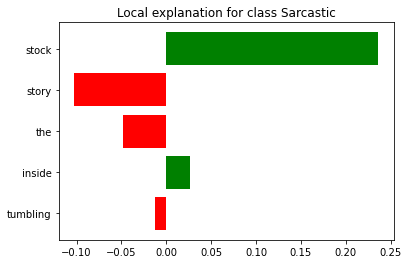

In [ ]:
misclass_indices=lr.misclass_indices 
pl = make_pipeline(dp2.vectorizer, lr.model)
explainer = LimeTextExplainer(class_names=['Non-sarcastic','Sarcastic'])
# idx=misclass_indices[8]
idx=450
exp = explainer.explain_instance(df['headline'].iloc[idx], pl.predict_proba, num_features=5)
%matplotlib inline
fig = exp.as_pyplot_figure()
print("Sentece: {}, Sarcastic? {}".format(df['headline'].iloc[idx],df['is_sarcastic'].iloc[idx]))

In [ ]:
# df.loc[df['is_sarcastic']==1]

Sentece: jealous gps clearly wants man to back over wife, Sarcastic? 1


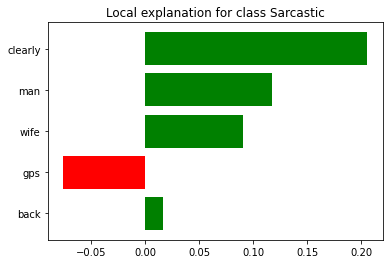

In [ ]:
idx=102
exp = explainer.explain_instance(df['headline'].iloc[idx], pl.predict_proba, num_features=5)
%matplotlib inline
fig = exp.as_pyplot_figure()
print("Sentece: {}, Sarcastic? {}".format(df['headline'].iloc[idx],df['is_sarcastic'].iloc[idx]))

In [ ]:
svm=SVM()
svm.train(dp2.X_train,dp2.y_train,validation_split)

In [ ]:
svm.evaluate(dp2.X_test,dp2.y_test)

{'accuracy': 0.934152659798783, 'conf_matrix': array([[8550,  423],
        [ 670, 6956]]), 'f1': 0.9335397810653013, 'precision': 0.9350035232187021, 'recall': 0.9325006227704882}

In [ ]:
nb_acc=[]
nb_alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for alpha in nb_alpha:
    nb=NaiveBayes(alpha)
    nb.train(dp2.X_train,dp2.y_train,validation_split)
    nb_acc.append(nb.evaluate(dp2.X_test,dp2.y_test)['accuracy'])

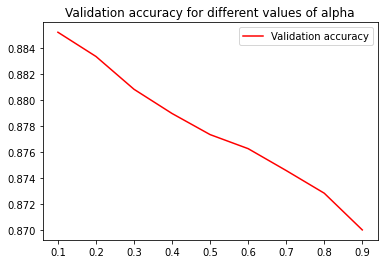

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(nb_alpha, nb_acc, 'r', label = 'Validation accuracy')
plt.title('Validation accuracy for different values of alpha')
plt.legend()
plt.figure()
plt.show()

In [ ]:
nb=NaiveBayes(alpha)
nb.train(dp2.X_train,dp2.y_train,validation_split)
nb.evaluate(dp2.X_test,dp2.y_test)

{'accuracy': 0.8699921682029038, 'conf_matrix': array([[8253,  720],
        [1438, 6188]]), 'f1': 0.8679484559639365, 'precision': 0.873693958607599, 'recall': 0.8655969218960317}

Keras Model for News Headline dataset

In [ ]:
max_len = 100
max_words = 10000
embedding_dim = 100
batch_size = 300
epochs = 10
validation_split=0.3

In [ ]:
dp=DataProcessor(df,max_len,max_words,0.3)
net=NeuralNet(max_len,max_words,embedding_dim)
net.visualize()
net.train(dp.X_train,dp.y_train,batch_size,epochs,validation_split)

Epoch 1/10
91/91 [==============================] - 7s 70ms/step - loss: 0.6270 - accuracy: 0.6327 - val_loss: 0.3327 - val_accuracy: 0.8551
Epoch 2/10
91/91 [==============================] - 6s 67ms/step - loss: 0.2455 - accuracy: 0.9049 - val_loss: 0.2465 - val_accuracy: 0.9046
Epoch 3/10
91/91 [==============================] - 6s 68ms/step - loss: 0.1156 - accuracy: 0.9641 - val_loss: 0.2335 - val_accuracy: 0.9148
Epoch 4/10
91/91 [==============================] - 6s 68ms/step - loss: 0.0474 - accuracy: 0.9903 - val_loss: 0.2491 - val_accuracy: 0.9173
Epoch 5/10
91/91 [==============================] - 6s 67ms/step - loss: 0.0207 - accuracy: 0.9966 - val_loss: 0.2683 - val_accuracy: 0.9189
Epoch 6/10
91/91 [==============================] - 6s 68ms/step - loss: 0.0100 - accuracy: 0.9988 - val_loss: 0.2893 - val_accuracy: 0.9199
Epoch 7/10
91/91 [==============================] - 6s 68ms/step - loss: 0.0062 - accuracy: 0.9992 - val_loss: 0.3142 - val_accuracy: 0.9178
Epoch 8/10
91

In [ ]:
net.evaluate(dp.X_test,dp.y_test)

{'accuracy': 0.45984697873365865, 'conf_matrix': array([[3909, 5064],
        [3902, 3724]]), 'f1': 0.45977987443117163, 'precision': 0.4621038791564503, 'recall': 0.46198482675932334}

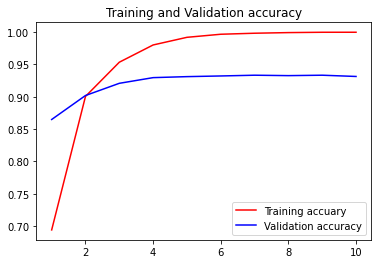

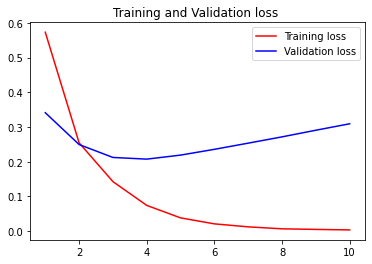

In [ ]:
net.plot_loss_acc()

ML Models for Reddit dataset

In [ ]:
max_len = 100
max_words = 10000
embedding_dim = 100
batch_size = 300
epochs = 10
validation_split=0.3

In [ ]:
dp3=DataProcessor_3(df2,max_len,max_words,0.3)

0                                                nc nh
1     know west teams play west teams east teams right
2    underdogs earlier today since gronks announcem...
3                  meme funny none new york nigga ones
4                                  could use one tools
Name: comment, dtype: object


In [ ]:
lr=LogisticReg()
lr.train(dp3.X_train,dp3.y_train,validation_split)

In [ ]:
lr.evaluate(dp3.X_test,dp3.y_test)

{'accuracy': 0.5314478682988603, 'conf_matrix': array([[88428, 62927],
        [79153, 72724]]), 'f1': 0.5301877979137759, 'precision': 0.5318921172932762, 'recall': 0.5315385953885392}

In [ ]:
#$svm is omitted because it was taking a very long time to execute
# svm=SVM()
# svm.train(dp3.X_train,dp3.y_train,validation_split)

In [ ]:
# svm.evaluate(dp3.X_test,dp3.y_test)

In [ ]:
nb=NaiveBayes(0.1)
nb.train(dp3.X_train,dp3.y_train,validation_split)
nb.evaluate(dp3.X_test,dp3.y_test)

{'accuracy': 0.5272035932883073, 'conf_matrix': array([[ 24356, 126999],
        [ 16368, 135509]]), 'f1': 0.4538143123913628, 'precision': 0.5571419375600561, 'recall': 0.5265741359102557}

Keras Model for Reddit dataset

In [ ]:
net=NeuralNet(max_len,max_words,embedding_dim)
net.train(dp3.X_train,dp3.y_train,batch_size,epochs,validation_split)

Epoch 1/10
1651/1651 [==============================] - 109s 66ms/step - loss: 0.6235 - accuracy: 0.6408 - val_loss: 0.5872 - val_accuracy: 0.6854
Epoch 2/10
1651/1651 [==============================] - 108s 66ms/step - loss: 0.5678 - accuracy: 0.7022 - val_loss: 0.5885 - val_accuracy: 0.6846
Epoch 3/10
1651/1651 [==============================] - 108s 66ms/step - loss: 0.5387 - accuracy: 0.7209 - val_loss: 0.6041 - val_accuracy: 0.6789
Epoch 4/10
1651/1651 [==============================] - 109s 66ms/step - loss: 0.5046 - accuracy: 0.7410 - val_loss: 0.6319 - val_accuracy: 0.6734


In [ ]:
net.evaluate(dp3.X_test,dp3.y_test)

{'accuracy': 0.6721487178134233, 'conf_matrix': array([[105947,  45408],
        [ 54007,  97870]]), 'f1': 0.6719159434052312, 'precision': 0.6727184157486623, 'recall': 0.6721965630962288}

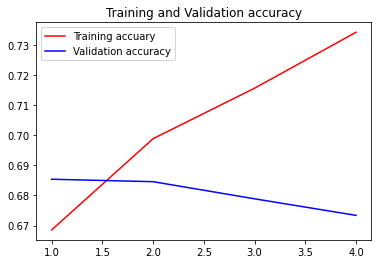

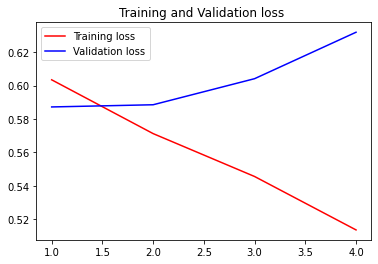

In [ ]:
net.plot_loss_acc()

BERT for News Dataset

In [ ]:
max_len = 100
max_words = 10000
embedding_dim = 100
batch_size = 300
epochs = 10
validation_split=0.3
dp4=DataProcessor_4(df,max_len,max_words,0.3)
net=BERT(max_len,max_words,embedding_dim)
net.visualize()
net.train(dp.X_train,dp.y_train,batch_size,epochs,validation_split)

In [ ]:
net.evaluate(dp4.X_test,dp4.y_test)

In [ ]:
net.plot_loss_acc()